- Design U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import gdown

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Conv2DTranspose, Concatenate
from keras.models import Model

import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro T2000, compute capability 7.5


# `+` Seed Value

In [3]:
SEED = 29

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download('https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

In [ ]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

In [4]:
# Training Dataset

def convert_bmp_to_png():
    folders = ['grey', 'mask']
    base_input_dir = 'Lung_Data'
    base_output_dir = 'Lung_Data_PNG'
    
    for folder in folders:
        out_dir = os.path.join(base_output_dir, folder)
        os.makedirs(out_dir, exist_ok=True)
        
        for img_path in glob(os.path.join(base_input_dir, folder, '*.bmp')):
            filename = os.path.basename(img_path)
            filename_no_ext = os.path.splitext(filename)[0]
            output_path = os.path.join(out_dir, f"{filename_no_ext}.png")
            Image.open(img_path).save(output_path, 'PNG')
        
        print(f"Converted images in {folder} folder to PNG format")

convert_bmp_to_png()

Converted images in grey folder to PNG format
Converted images in mask folder to PNG format


In [5]:
grey_train, grey_val = image_dataset_from_directory(
    'Lung_Data_PNG/grey',
    labels=None,
    color_mode='grayscale',
    image_size=(512, 512),
    batch_size=2,
    seed=SEED,
    validation_split=0.2,
    subset="both",
)

mask_train, mask_val = image_dataset_from_directory(
    'Lung_Data_PNG/mask',
    labels=None,
    color_mode='grayscale',
    image_size=(512, 512),
    batch_size=2,
    seed=SEED,
    validation_split=0.2,
    subset="both",
)

Found 216 files belonging to 1 classes.
Using 173 files for training.
Using 43 files for validation.
Found 216 files belonging to 1 classes.
Using 173 files for training.
Using 43 files for validation.


The transformation must be applied to both image and corresponding mask 

In [6]:
train_ds = tf.data.Dataset.zip((grey_train, mask_train))
val_ds = tf.data.Dataset.zip((grey_val, mask_val))

In [8]:
def augment_data(images, masks):

    images = tf.cast(images, tf.float32) / 255.0
    masks = tf.cast(masks, tf.float32) / 255.0

    do_flip = tf.random.uniform([]) > 0.5
    images = tf.cond(do_flip, lambda: tf.image.flip_left_right(images), lambda: images)
    masks = tf.cond(do_flip, lambda: tf.image.flip_left_right(masks), lambda: masks)

    angle = tf.random.uniform([], -0.05, 0.05) * 2 * 3.1415926
    images = tfa.image.rotate(images, angle, interpolation='BILINEAR')
    masks = tfa.image.rotate(masks, angle, interpolation='NEAREST')

    images = tf.image.random_brightness(images, 0.1)
    images = tf.image.random_contrast(images, 0.9, 1.1)
    
    images = tf.clip_by_value(images, 0.0, 1.0)
    
    return images, masks


In [9]:
augmented_train_ds = train_ds.map(lambda img, msk: augment_data(img, msk), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
augmented_val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32) / 255.0), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

### Preview the Images

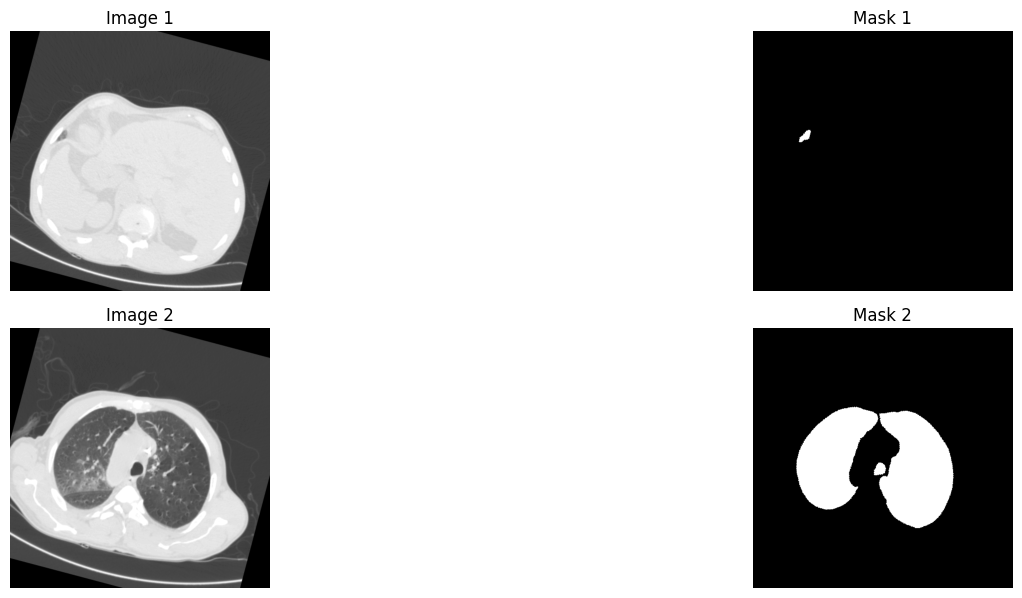

In [10]:
# Preview Images
plt.figure(figsize=(15, 15), dpi=100)
for images, masks in augmented_train_ds.take(4):
    for i in range(2):
        plt.subplot(5, 2, i*2 + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i+1}")
        plt.subplot(5, 2, i*2 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Mask {i+1}")

plt.tight_layout()
plt.show()

## `+` Set Global Parameters

In [10]:
# Hyperparameters
BATCH_SIZE = 2
EPOCHS = 50
LEARNING_RATE = 1e-4

## `i` Model Design

In [11]:
def double_conv(x, n_filters, dropout_rate=0.0):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters, dropout_rate=0.0):
    f = double_conv(x, n_filters, dropout_rate) 
    p = MaxPooling2D(2)(f)
    return f, p

def upsample_block(x, skip_features, n_filters, dropout_rate=0.0):
    x = Conv2DTranspose(n_filters, (3, 3), strides=2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = double_conv(x, n_filters, dropout_rate)
    return x

In [14]:
inputs = Input((512, 512, 1))

s1, p1 = downsample_block(inputs, 64)
s2, p2 = downsample_block(p1, 128)
s3, p3 = downsample_block(p2, 256, dropout_rate=0.1)

bottleneck = double_conv(p3, 512, dropout_rate=0.2)

u1 = upsample_block(bottleneck, s3, 256, dropout_rate=0.1)
u2 = upsample_block(u1, s2, 128)
u3 = upsample_block(u2, s1, 64)

outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same', dtype="float32")(u3)

model = Model(inputs, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## `ii` Model Compilation & Training

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
optimizer = keras.optimizers.Adam(learning_rate= LEARNING_RATE)

In [16]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(augmented_train_ds,validation_data=augmented_val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE, callbacks=[early_stopping], verbose=1)

Epoch 1/50
87/87 [==============================] - 270s 2s/step - loss: 0.4009 - accuracy: 0.8791 - val_loss: 0.3175 - val_accuracy: 0.8905
Epoch 2/50
87/87 [==============================] - 119s 1s/step - loss: 0.2927 - accuracy: 0.8924 - val_loss: 0.2703 - val_accuracy: 0.8905
Epoch 3/50
87/87 [==============================] - 119s 1s/step - loss: 0.2606 - accuracy: 0.8924 - val_loss: 0.2662 - val_accuracy: 0.8905
Epoch 4/50
87/87 [==============================] - 119s 1s/step - loss: 0.2469 - accuracy: 0.8906 - val_loss: 0.2492 - val_accuracy: 0.8905
Epoch 5/50
87/87 [==============================] - 119s 1s/step - loss: 0.2303 - accuracy: 0.8892 - val_loss: 0.2448 - val_accuracy: 0.8905
Epoch 6/50
87/87 [==============================] - 119s 1s/step - loss: 0.1850 - accuracy: 0.9166 - val_loss: 0.1740 - val_accuracy: 0.9211
Epoch 7/50
87/87 [==============================] - 119s 1s/step - loss: 0.0879 - accuracy: 0.9716 - val_loss: 0.0816 - val_accuracy: 0.9739
Epoch 8/50
87

## `iii` Result Visualization

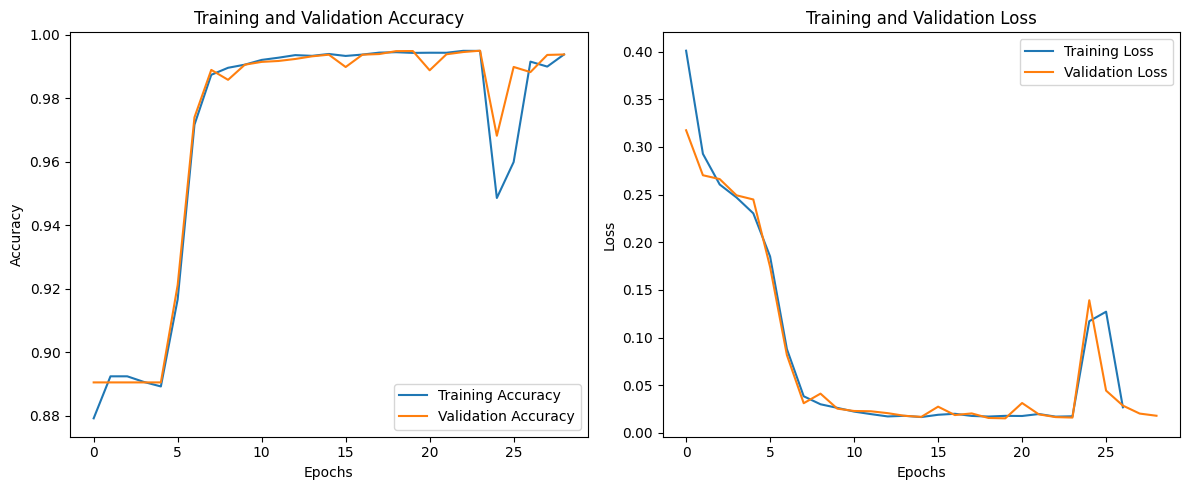

In [17]:
# Plot the training and validation accuracy and loss
history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## `iv` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [34]:
# segment the image
def segment_image(image_path):
    image = Image.open(image_path).convert('L')
    image = image.resize((512, 512))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)

    prediction = model.predict(image)
    prediction = np.squeeze(prediction) * 255.0
    
    prediction = Image.fromarray(prediction.astype(np.uint8))

    return prediction, image

1/1 [==============================] - 0s 24ms/step


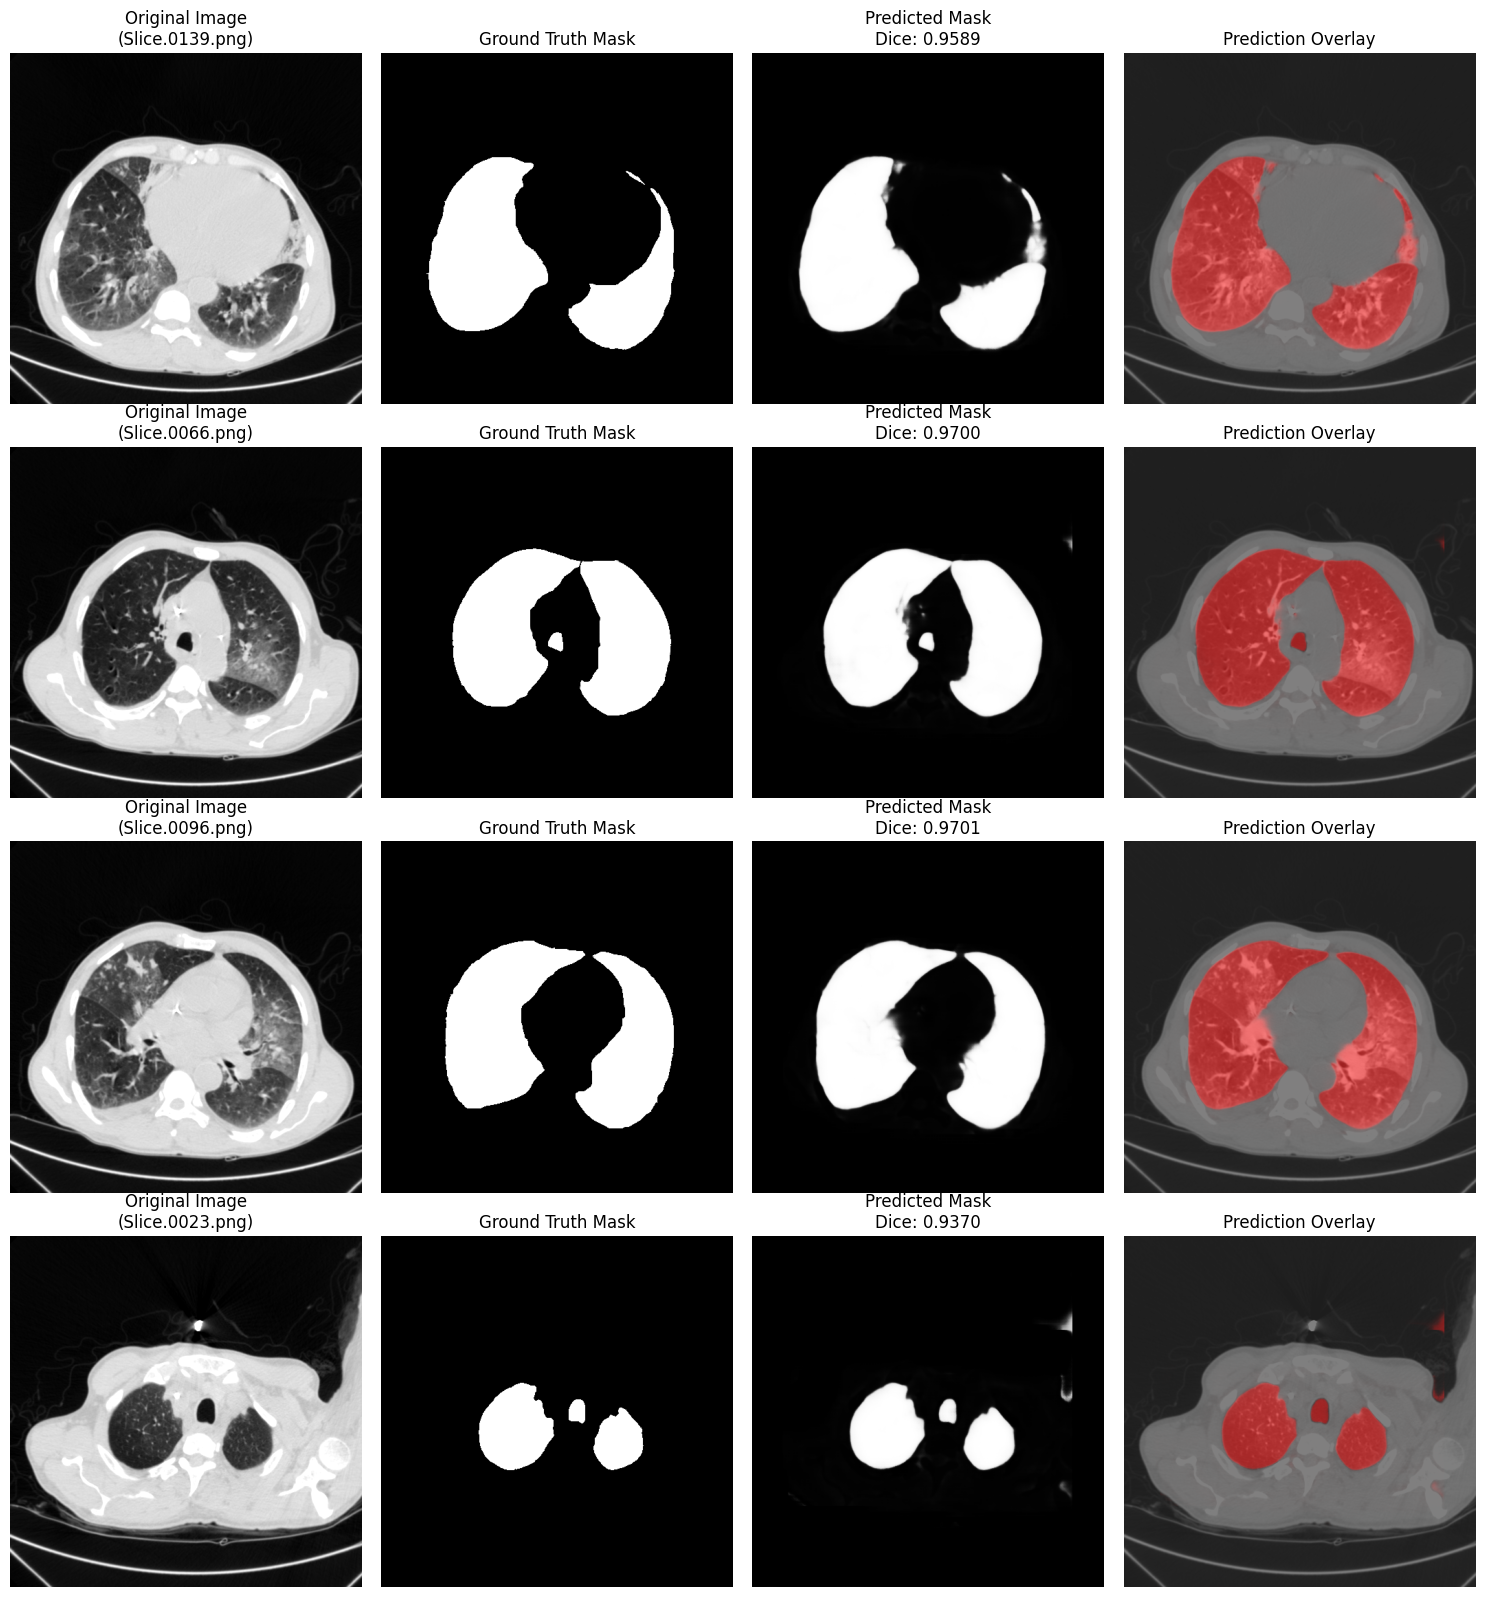

In [35]:
def visualize_random_samples_with_overlay(num_samples=5, seed=None):

    if seed is not None:
        np.random.seed(seed)
    
    test_images = glob(os.path.join('Lung_Data_PNG/grey', '*.png'))
    
    if len(test_images) > num_samples:
        selected_images = np.random.choice(test_images, num_samples, replace=False)
    else:
        selected_images = test_images
    
    plt.figure(figsize=(15, 4*num_samples))
    
    for i, img_path in enumerate(selected_images):
        img_name = os.path.basename(img_path)
        mask_path = os.path.join('Lung_Data_PNG/mask', img_name)
        
        if not os.path.exists(mask_path):
            continue
            
        predicted_mask, input_image = segment_image(img_path)
        original_img = np.squeeze(input_image[0])
        
        # True mask
        true_mask = Image.open(mask_path).convert('L')
        true_mask = true_mask.resize((512, 512))
        true_mask = np.array(true_mask) / 255.0
        
        # Predicted mask
        predicted_mask = np.array(predicted_mask) / 255.0
        
        # Calculate Dice coefficient
        true_flat = true_mask.flatten()
        pred_flat = predicted_mask.flatten()
        intersection = np.sum(true_flat * pred_flat)
        dice = (2. * intersection + 1e-8) / (np.sum(true_flat) + np.sum(pred_flat) + 1e-8)
        
        # Original image
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(original_img, cmap='gray')
        plt.axis('off')
        plt.title(f"Original Image\n({img_name})")
        
        # True mask
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Ground Truth Mask")
        
        # Predicted mask
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Predicted Mask\nDice: {dice:.4f}")
        
        # Overlay of image and prediction
        plt.subplot(num_samples, 4, i*4+4)
        
        # Create a RGB image from grayscale
        rgb_img = np.stack([original_img]*3, axis=-1)
        
        # Create a red mask for the prediction
        red_mask = np.zeros_like(rgb_img)
        red_mask[:,:,0] = predicted_mask * 1.0  # Red channel
        
        # Blend with transparency
        alpha = 0.5
        blended = rgb_img * (1-alpha) + red_mask * alpha
        
        plt.imshow(blended)
        plt.axis('off')
        plt.title("Prediction Overlay")
    
    plt.tight_layout()
    plt.show()

visualize_random_samples_with_overlay(num_samples=4, seed=7)

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.